In [1]:
from Bio import SeqIO
from itertools import cycle
import warnings
import numpy as np
from dna_features_viewer import GraphicFeature, GraphicRecord, BiopythonTranslator
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
seq = SeqIO.read("<path_to>/hiv1_sequence.gb",'genbank')

In [52]:
seq.id

'NC_001802.1'

In [3]:
X_CODONS =  set(["AAC","AAT","ACC","ATC","ATT","CAG","CTC","CTG","GAA","GAC","GAG","GAT","GCC","GGC","GGT",
                 "GTA","GTC","GTT","TAC","TTC"])

In [5]:
def x_motif(x):
    frame_open = 0
    frame_score = 0
    codon_set = set()
    if len(x)%3 != 0:
        warnings.warn("This sequence is not divisible by 3 and will be truncated by {} bases.".format(len(x)%3))
    for i in range(0,len(x)-(len(x)%3),3):
        if x[i:i+3] in X_CODONS:
            frame_open += 3
            codon_set.update([x[i:i+3]])
        elif frame_open > 6 and len(codon_set) > 1:
            frame_score += frame_open
            frame_open = 0
            codon_set = set()
        else:
            frame_open = 0
            codon_set = set()
    else:
        #flush frame_open buffer once end of loop is reached
        #without this last X motif in sequence is never counted
        if frame_open > 6 and len(codon_set) > 1:
            frame_score += frame_open
    return frame_score

In [6]:
x_motif(str(seq.seq[2:]))

C:\Users\notor\AppData\Local\Temp\ipykernel_37164\3372388519.py:6: UserWarning: This sequence is not divisible by 3 and will be truncated by 2 bases.
  warnings.warn("This sequence is not divisible by 3 and will be truncated by {} bases.".format(len(x)%3))


453

In [12]:
#rewrite get_scores to only do a sliding window withing the give reading frame takes as argument complete sequence
#and intervals dict
def get_scores(seq,interval_dict,window_size=150):
    scores_dict = {frame:np.zeros(len(range(frame,len(seq)-window_size,3))) for frame in interval_dict.keys()}
    for frame in interval_dict.keys():
        for interval in interval_dict[frame]:
            for i in range(interval[0],interval[1]-window_size,3):
                scores_dict[frame][i//3] = x_motif(seq[i:i+window_size])
    return scores_dict
    

In [15]:
def find_orfs(seq, min_length=120):
    """
    Find ORFs in all three forward reading frames of a nucleotide sequence.

    Parameters:
        seq (str): DNA sequence (string of A, T, G, C).
        min_length (int): Minimum ORF length in nucleotides.

    Returns:
        dict: Keys are 0, 1, 2 for the reading frames; values are lists of (start, stop) tuples.
    """
    seq = seq.upper()
    stop_codons = {'TAA', 'TAG', 'TGA'}
    start_codon = 'ATG'
    orfs = {0: [], 1: [], 2: []}

    for frame in range(3):
        i = frame
        while i < len(seq) - 2:
            codon = seq[i:i+3]
            if codon == start_codon:
                start = i
                j = i + 3
                while j < len(seq) - 2:
                    stop_codon = seq[j:j+3]
                    if stop_codon in stop_codons:
                        end = j + 3  # include stop codon
                        if end - start >= min_length:
                            orfs[frame].append((start, end))
                        break
                    j += 3
                i = j  # jump to the end of the ORF or next codon after failed ORF
            else:
                i += 3
    return orfs

In [9]:
#TODO: In order to do XME normalization, we will take the intervals generated in orf_list and perform a bedtools coverage operation
#with the -d flag to give per-base coverage. This allows normalization of the gofix scores on a per-coordinate basis for overlapping orfs

In [16]:
orf_list = find_orfs(str(seq.seq))

In [17]:
orf_list

{0: [(3954, 4122), (5376, 5595), (5607, 5856)],
 1: [(796, 955), (1903, 4642), (5104, 5341), (5770, 8341)],
 2: [(335, 1838), (4586, 5165), (5888, 6023), (8342, 8714)]}

In [12]:
'''
frame_array = np.zeros(len(seq))
for frame in orf_list:
    for intervals in orf_list[frame]:
        new_orf = np.zeros(len(seq))
        new_orf[intervals[0]:intervals[1]] += 1
        frame_array = frame_array + new_orf
'''

In [18]:
frame_array = {}
for frame in orf_list:
    new_orf = np.zeros(len(seq))
    for intervals in orf_list[frame]:
        new_orf[intervals[0]:intervals[1]] += 1
    frame_array[frame] = new_orf


In [19]:
frame_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
#TODO: Get scores by iterating through intervals list instead of full sequence
window_size = 150
raw_scores = get_scores(str(seq.seq),orf_list,window_size)

In [21]:
print(len(raw_scores[0]))
print(len(raw_scores[1]))
print(len(raw_scores[2]))

3011
3010
3010


In [22]:
frame_set = set([0,1,2])
print(frame_set - set([1]))

{0, 2}


In [23]:
gofix_scores = {}
frame_set = set([0,1,2])
lf_debug = []
array_range = min([len(raw_scores[f]) for f in raw_scores.keys()])
for frame in raw_scores:
    new_score = []
    #Score is XL_f
    for i,score in enumerate(range(array_range)):
        #Need to calculate l_f
        l_f = window_size
        for other_frame in frame_set - set([frame]):
            l_f -= raw_scores[other_frame][i] * np.max(frame_array[other_frame][(i*3)+other_frame:(i*3)+window_size])
        new_score.append((100/l_f)*raw_scores[frame][i])
        lf_debug.append(l_f)
    gofix_scores[frame] = np.array(new_score)
        

In [24]:
100/min(lf_debug)

1.1111111111111112

In [25]:
gofix_scores[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
np.where(frame_array[0] !=0)

(array([3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964,
        3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975,
        3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986,
        3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997,
        3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008,
        4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019,
        4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030,
        4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041,
        4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052,
        4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063,
        4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074,
        4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085,
        4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096,
        4097, 4098, 4099, 4100, 4101, 

In [27]:
seq.features = [f for f in seq.features if f.type == 'CDS']

In [28]:
feature_frames = {f.qualifiers['gene'][0]:f.location.start%3 for f in seq.features}

In [29]:
feature_frames

{'gag-pol': 2,
 'gag': 2,
 'vif': 2,
 'vpr': 1,
 'tat': 0,
 'rev': 1,
 'vpu': 0,
 'env': 1,
 'asp': 0,
 'nef': 2}

In [30]:
color_dict = {0:'#f14722',1:'#26deba',2:'#dd7cee'}

In [31]:
#graphic_record = BiopythonTranslator().translate_record("C:/Users/notor/Documents/Phil_School_2024/Phil_School_2024/Seto_lab_rotation/sars2_refseq.gb")
graphic_record = BiopythonTranslator().translate_record(seq)


In [32]:
for gf in graphic_record.features:
    gf.color = color_dict[feature_frames[gf.label]]

In [42]:
for f in graphic_record.features:
    print(f.label,f.start,f.end)

gag-pol 335 4642
gag 335 1838
vif 4586 5165
vpr 5104 5396
tat 5376 7970
rev 5515 8199
vpu 5607 5856
env 5770 8341
asp 6918 7488
nef 8342 8963


In [44]:
len(seq)-7488

1693

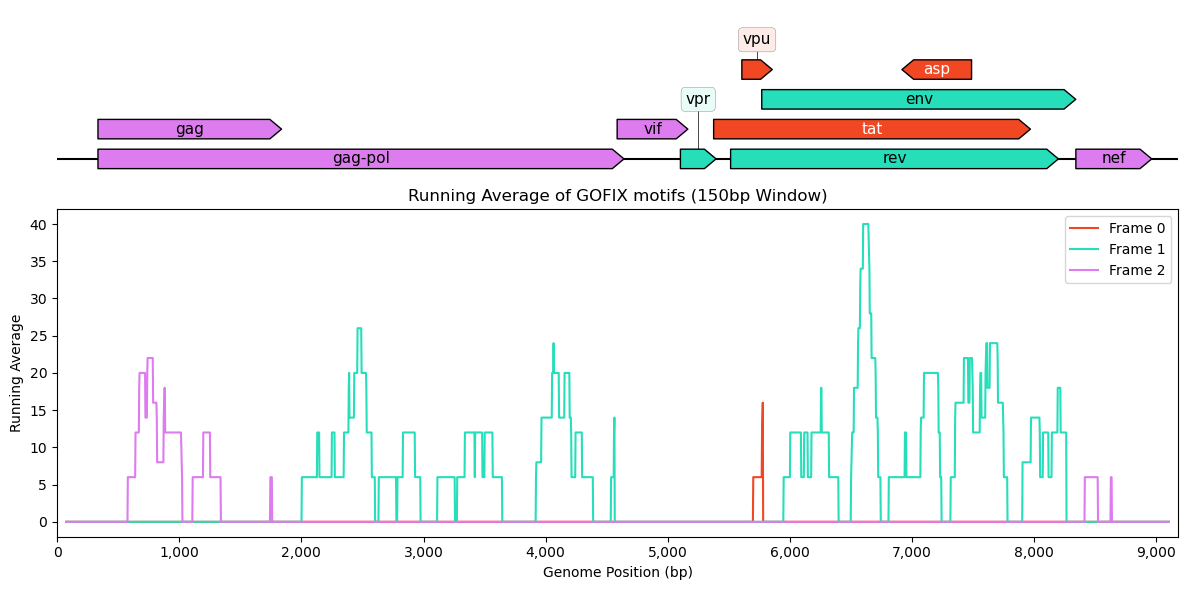

In [34]:
#whole genome
x_positions_frame_1 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[0]))]
x_positions_frame_2 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[1]))]
x_positions_frame_3 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[2]))]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True,
                               gridspec_kw={"height_ratios": [1, 2]})
graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=7)
ax2.plot(x_positions_frame_1, gofix_scores[0], label="Frame 0",color=color_dict[0])
ax2.plot(x_positions_frame_2, gofix_scores[1], label="Frame 1",color=color_dict[1])
ax2.plot(x_positions_frame_3, gofix_scores[2], label="Frame 2",color=color_dict[2])
ax2.set_ylabel("Running Average")
ax2.set_xlabel("Genome Position (bp)")
ax2.legend()
ax2.set_title("Running Average of GOFIX motifs (150bp Window)")

plt.tight_layout()
plt.show()

75

In [76]:
#TODO: Graph reverse strand

In [35]:
rev_seq = seq.seq.reverse_complement()
rev_orf_list = find_orfs(str(rev_seq))


In [36]:
rev_orf_list

{0: [(2421, 2619), (3096, 3246), (6381, 6510), (8139, 8265), (8286, 8415)],
 1: [(268, 442),
  (1354, 1501),
  (1693, 2263),
  (2413, 2641),
  (2917, 3073),
  (3112, 3295),
  (4603, 4729),
  (4783, 4906),
  (5785, 6061),
  (6691, 6817),
  (6898, 7111)],
 2: [(3491, 3611), (6050, 6239), (8414, 8546)]}

In [37]:
rev_raw_scores = get_scores(str(rev_seq),rev_orf_list,window_size)

In [38]:
rev_gofix_scores = {}
frame_set = set([0,1,2])
lf_debug = []
array_range = min([len(rev_raw_scores[f]) for f in rev_raw_scores.keys()])
for frame in rev_raw_scores:
    new_score = []
    #Score is XL_f
    for i,score in enumerate(range(array_range)):
        #Need to calculate l_f
        l_f = window_size
        for other_frame in frame_set - set([frame]):
            l_f -= rev_raw_scores[other_frame][i] * np.max(frame_array[other_frame][(i*3)+other_frame:(i*3)+window_size])
        new_score.append((100/l_f)*rev_raw_scores[frame][i])
        lf_debug.append(l_f)
    rev_gofix_scores[frame] = np.array(new_score)

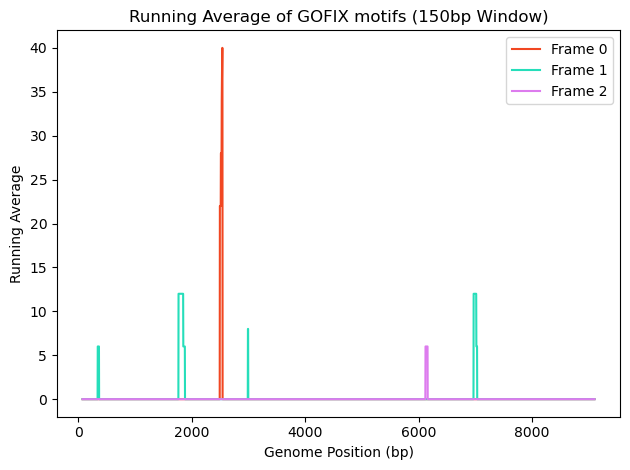

In [39]:
#whole genome
rev_x_positions_frame_1 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[0]))]
rev_x_positions_frame_2 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[1]))]
rev_x_positions_frame_3 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[2]))]
plt.plot(rev_x_positions_frame_1, rev_gofix_scores[0], label="Frame 0",color=color_dict[0])
plt.plot(rev_x_positions_frame_2, rev_gofix_scores[1], label="Frame 1",color=color_dict[1])
plt.plot(rev_x_positions_frame_3, rev_gofix_scores[2], label="Frame 2",color=color_dict[2])
plt.ylabel("Running Average")
plt.xlabel("Genome Position (bp)")
plt.legend()
plt.title("Running Average of GOFIX motifs (150bp Window)")

plt.tight_layout()
plt.show()

In [47]:
str(rev_seq[1693: 2263].translate())

'MPQTVSCNRCCCASIALSKLFCCCTIPDNNCLACTVSVIEAAPIVLPAAPKNPRNKAPIPTALFSLCTTLLFALVGATPNGSIFTTLYLYNSLLQLSLISPPPGLKISDSLLLLPPSLVNSSPVIFDEHLICPLMGGAYIAFPTFCHMFIICFILHGRVIVSLPSVLFDPSVLQVLLNQVLLNSCVELQ*'

In [48]:
len(seq) - 7488

1693

In [50]:
str(rev_seq[2413:2641].translate())

'MLQCACLIFPIFPIVTNALPGPLWIRILFLVLLLGLVQLISTDVFSCTIMVLALSVKLTDLITTSSSARLPFNSS*'

In [51]:
len(seq) - 2641

6540

In [54]:
str(rev_seq[6898: 7111])

'ATGGCAAATACTGGAGTATTGTATGGATTTTCAGGCCCAATTTTTGAAATTTTCCCTTCCTTTTCCATCTCTGTACAAATTTCTACTAATGCTTTTATTTTTTCTTCTGTCAATGGCCATTGTTTAACTTTTGGGCCATCCATTCCTGGCTTTAATTTTACTGGTACAGTCTCAATAGGGCTAATGGGAAAATTTAAAGTGCAACCAATCTGA'